In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:
data = np.load('./../../ml/origen/Data.npy', allow_pickle=True).item()

# EDA

Before we begin with let us visualise the data
the keys are ["pressure", "u", "v", x and y]

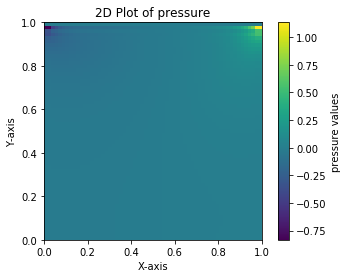

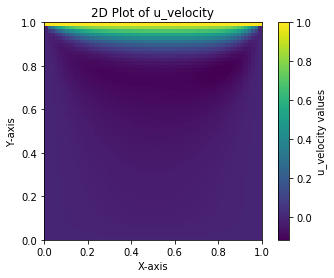

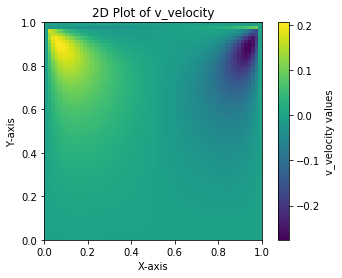

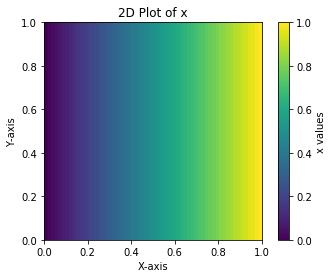

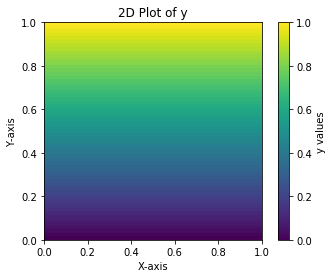

In [190]:
# Loop through all keys in the dictionary
for key in data.keys():
    # Get the array associated with the key
    array_data = data[key]

    # Check if the array is 2D (for simplicity)
    if len(array_data.shape) == 2:
        # Create a 2D plot
        plt.imshow(array_data, cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
        plt.colorbar(label=f'{key} values')
        plt.title(f'2D Plot of {key}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

The above plots makes sense u is one at the top as mentioned in the question for lid-cavity flow and, v is parallel to y axis indicating max around top corner and pressure is on avg zero and

In [4]:
#getting items from input file 
u_velocity = data['u_velocity']
v_velocity = data['v_velocity']
pressure = data['pressure']
x_coords = data['x']
y_coords = data['y']



In [4]:
print(f'u_velocity : {u_velocity.shape}') 
print(f'v_velocity : {v_velocity.shape}') 
print(f'pressure : {pressure.shape}') 
print(f'x_coords : {x_coords.shape}') 
print(f'y_coords : {y_coords.shape}') 


u_velocity : (61, 61)
v_velocity : (61, 61)
pressure : (61, 61)
x_coords : (61, 61)
y_coords : (61, 61)


randomly sampling the data 

In [5]:
# Assuming the size of your grid is (61, 61)
grid_size = (50, 50) # reduing the grid size so that it doesnt take boundaruy
# randomly choosing to be 50


In [6]:
# Generate random indices for the rows and columns excluding boundaries
random_rows = np.random.choice(np.arange(1, grid_size[0] - 1), size=100, replace=True)
random_cols = np.random.choice(np.arange(1, grid_size[1] - 1), size=100, replace=True)

# Combine row and column indices to create 2D indices
random_indices_2d = np.column_stack((random_rows, random_cols))


In [8]:
x_coords_at_selected_points = x_coords[random_indices_2d[:, 0], random_indices_2d[:, 1]]
y_coords_at_selected_points = y_coords[random_indices_2d[:, 0], random_indices_2d[:, 1]]
pressure_at_selected_points = pressure[random_indices_2d[:, 0], random_indices_2d[:, 1]]
uVelocity_at_selected_points = u_velocity[random_indices_2d[:, 0], random_indices_2d[:, 1]]
vVelocity_at_selected_points = v_velocity[random_indices_2d[:, 0], random_indices_2d[:, 1]]


In [153]:
#### Validation
# Generate random indices for the rows and columns excluding boundaries
val_rows = np.random.choice(np.arange(1, grid_size[0] - 1), size=100, replace=True)
val_cols = np.random.choice(np.arange(1, grid_size[1] - 1), size=100, replace=True)

# Combine row and column indices to create 2D indices
val_indices_2d = np.column_stack((val_rows, val_cols))
valx_coords_at_selected_points = x_coords[val_indices_2d[:, 0], val_indices_2d[:, 1]]
valy_coords_at_selected_points = y_coords[val_indices_2d[:, 0], val_indices_2d[:, 1]]
valpressure_at_selected_points = pressure[val_indices_2d[:, 0], val_indices_2d[:, 1]]
valuVelocity_at_selected_points = u_velocity[val_indices_2d[:, 0], val_indices_2d[:, 1]]
valvVelocity_at_selected_points = v_velocity[val_indices_2d[:, 0], val_indices_2d[:, 1]]


In [35]:
# Define the neural network model
class phypropPredictor(nn.Module):
    def __init__(self):
        super(phypropPredictor, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()

        # Three output layers for three properties
        self.fc3_P = nn.Linear(32, 1)  # Output for property P
        self.fc3_u = nn.Linear(32, 1)  # Output for property u
        self.fc3_v = nn.Linear(32, 1)  # Output for property v

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))

        # Three separate output layers
        output_P = self.fc3_P(x)  # Output for property P
        output_u = self.fc3_u(x)  # Output for property u
        output_v = self.fc3_v(x)  # Output for property v

        return output_P, output_u, output_v

In [36]:
model = phypropPredictor()
model

phypropPredictor(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3_P): Linear(in_features=32, out_features=1, bias=True)
  (fc3_u): Linear(in_features=32, out_features=1, bias=True)
  (fc3_v): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
# normalise and scale the data
scaler = StandardScaler()
norm_x_coords = scaler.fit_transform(x_coords_at_selected_points.reshape(-1,1))
norm_y_coords= scaler.fit_transform(y_coords_at_selected_points.reshape(-1,1))
norm_pressure = scaler.fit_transform(pressure_at_selected_points.reshape(-1,1))
norm_uVelocity = scaler.fit_transform(uVelocity_at_selected_points.reshape(-1,1))
norm_vVelocity = scaler.fit_transform(vVelocity_at_selected_points.reshape(-1,1))

since we know it is a fluid in steadt state they are governed by the Navier-Stokes equation 

We can take conservation of momentum 
and continuity equation and put these as bounds 

\begin{align*}
\frac{\partial u}{\partial t} + (u \cdot \nabla)u &= - \nabla P +  \frac{1}{R_e}\nabla^2 u \\
\frac{\partial v}{\partial t} + (u \cdot \nabla)v &= - \nabla P +  \frac{1}{R_e}\nabla^2 v
\end{align*}

these are the same u,v and P that are given 
R_e = 100

for steady state $\frac{\partial u}{\partial t} = 0 and, \frac{\partial v}{\partial t} = 0 $ 

\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{\partial P}{\partial x} + \frac{1}{R_e} \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
\end{equation}


\begin{equation}
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial P}{\partial y} + \frac{1}{R_e} \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)
\end{equation}

\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\end{equation}

We can incorporate these in the Loss function and modify the loss 

## Loading data as xy - input, p,u,v target

In [14]:
# Assuming your data is in NumPy arrays
xy_np = np.concatenate((norm_x_coords, norm_y_coords), axis=1)
pressure_velocities_np = np.concatenate((norm_pressure, norm_uVelocity, norm_vVelocity), axis=1)


In [15]:

# Convert data to PyTorch tensors
xy = torch.FloatTensor(xy_np)
pressure_velocities = torch.FloatTensor(pressure_velocities_np)

In [159]:
val_xy_np = np.concatenate((valx_coords_at_selected_points.reshape(-1,1), valy_coords_at_selected_points.reshape(-1,1)), axis=1)
val_pressure_velocities_np = np.concatenate((valpressure_at_selected_points.reshape(-1,1), valuVelocity_at_selected_points.reshape(-1,1), valvVelocity_at_selected_points.reshape(-1,1)), axis=1)


In [160]:

# Convert data to PyTorch tensors
xy_val = torch.FloatTensor(val_xy_np)
pressure_velocities_val = torch.FloatTensor(val_pressure_velocities_np)

## Plots

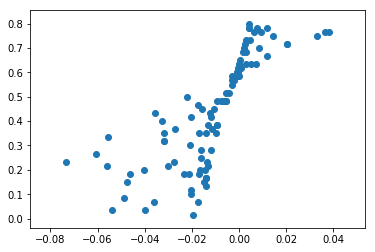

In [72]:
plt.scatter(pressure_at_selected_points,x_coords_at_selected_points )

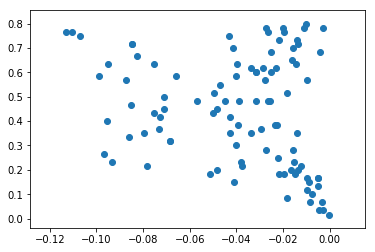

In [74]:
plt.scatter(uVelocity_at_selected_points,x_coords_at_selected_points )

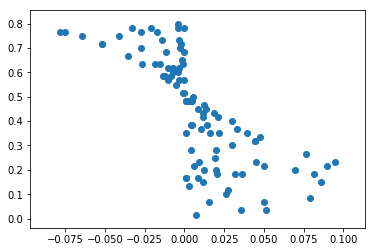

In [73]:
plt.scatter(vVelocity_at_selected_points,x_coords_at_selected_points )

# Loss Function

In [191]:

def pinnDeepLoss(input, target):
        R_e = 100
        x = input[:,0]
        y = input[:,1] 
        x.requires_grad = True
        y.requires_grad = True
        
        #pPred, uPred, vPred = cnn(input)

        pPred, uPred, vPred = model(input)

        #uPred.retain_grad().squeeze(dim = 1)
        #vPred.retain_grad().squeeze(dim = 1)
        #pPred.retain_grad().squeeze(dim = 1)
        u = uPred.squeeze(dim =1)
        v = vPred.squeeze(dim =1)
        P = pPred.squeeze(dim =1)
     #   print(u.shape)
    
        # where u,v, p are PredictedVariables
        dudx = torch.autograd.grad(uPred,x,grad_outputs=torch.ones_like(x),allow_unused=True,create_graph = True,only_inputs=True)[0]
        print(dudx)
        d2udx2 = torch.autograd.grad(dudx,x,grad_outputs=torch.ones_like(x),allow_unused=True,create_graph = True,only_inputs=True)[0]
        print(d2udx2)   
        dudy = torch.autograd.grad(u,y,grad_outputs=torch.ones_like(y),allow_unused=True,create_graph = True,only_inputs=True)[0]
        d2udy2 = torch.autograd.grad(dudy,y,grad_outputs=torch.ones_like(y),allow_unused=True,create_graph = True,only_inputs=True)[0]
        
        dvdx = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(x),allow_unused=True,create_graph = True,only_inputs=True)[0]
        d2vdx2 = torch.autograd.grad(dvdx,x,grad_outputs=torch.ones_like(x),allow_unused=True,create_graph = True,only_inputs=True)[0]
        
        dvdy = torch.autograd.grad(v,y,grad_outputs=torch.ones_like(y),allow_unused=True,create_graph = True,only_inputs=True)[0]
        d2vdy2 = torch.autograd.grad(dvdy,y,grad_outputs=torch.ones_like(y),allow_unused=True,create_graph = True,only_inputs=True)[0]
        dPdx = torch.autograd.grad(P,x,grad_outputs=torch.ones_like(x),allow_unused=True,create_graph = True,only_inputs=True)[0]
        dPdy = torch.autograd.grad(P,y,grad_outputs=torch.ones_like(y),allow_unused=True,create_graph = True,only_inputs=True)[0]
        
        loss_momentumX = u*dudx + v*dudy + dPdx - ((1/R_e)*(d2udx2 + d2udy2))
        loss_momentumY = u*dvdx + v*dvdy + dPdy - ((1/R_e)*(d2vdx2 + d2vdy2))
        loss_cont = dudx + dvdy

    # Mean Squared Error (MSE) for predicted u, v, and p compared to ground truth
        uTrue = target[:,1]
        vTrue = target[:,2]
        pTrue = target[:,0]
        print(uTrue.shape)
        loss_u_mse = nn.MSELoss()(u, uTrue)
        loss_v_mse = nn.MSELoss()(v, vTrue)
        loss_p_mse = nn.MSELoss()(P, pTrue)

    # Combine individual losses into the total loss
        total_loss_nn =  loss_u_mse+loss_v_mse+loss_p_mse
        total_loss = torch.mean(loss_momentumX**2 + loss_momentumY**2 + loss_cont**2) + total_loss_nn
        
        return total_loss

    

### optimisation

In [192]:
# Define the optimizer
learning_rate = 0.001 #{'lr' : }
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training

In [193]:
nEpoch = 100
# Training 
for epoch in range(nEpoch):

    optimizer.zero_grad()
    total_loss = pinnDeepLoss(xy, pressure_velocities)
    total_loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1} : Loss : {total_loss}')
    

torch.Size([100])
Epoch 1 : Loss : 2.2411043643951416
torch.Size([100])
Epoch 2 : Loss : 2.180720806121826
torch.Size([100])
Epoch 3 : Loss : 2.121795892715454
torch.Size([100])
Epoch 4 : Loss : 2.064445972442627
torch.Size([100])
Epoch 5 : Loss : 2.0085792541503906
torch.Size([100])
Epoch 6 : Loss : 1.95383882522583
torch.Size([100])
Epoch 7 : Loss : 1.9004614353179932
torch.Size([100])
Epoch 8 : Loss : 1.8485193252563477
torch.Size([100])
Epoch 9 : Loss : 1.797630786895752
torch.Size([100])
Epoch 10 : Loss : 1.748421311378479
torch.Size([100])
Epoch 11 : Loss : 1.70023775100708
torch.Size([100])
Epoch 12 : Loss : 1.652756929397583
torch.Size([100])
Epoch 13 : Loss : 1.6061286926269531
torch.Size([100])
Epoch 14 : Loss : 1.5605249404907227
torch.Size([100])
Epoch 15 : Loss : 1.5156279802322388
torch.Size([100])
Epoch 16 : Loss : 1.4715063571929932
torch.Size([100])
Epoch 17 : Loss : 1.4279730319976807
torch.Size([100])
Epoch 18 : Loss : 1.384971261024475
torch.Size([100])
Epoch 19 : L

In [194]:
nEpoch = 1000
# Training 
for epoch in range(nEpoch):

    optimizer.zero_grad()
    total_loss = pinnDeepLoss(xy, pressure_velocities)
    total_loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1} : Loss : {total_loss}')
    

torch.Size([100])
Epoch 1 : Loss : 0.1575542688369751
torch.Size([100])
Epoch 2 : Loss : 0.1554039865732193
torch.Size([100])
Epoch 3 : Loss : 0.15336376428604126
torch.Size([100])
Epoch 4 : Loss : 0.1513647735118866
torch.Size([100])
Epoch 5 : Loss : 0.14940524101257324
torch.Size([100])
Epoch 6 : Loss : 0.14748987555503845
torch.Size([100])
Epoch 7 : Loss : 0.1456337571144104
torch.Size([100])
Epoch 8 : Loss : 0.143811896443367
torch.Size([100])
Epoch 9 : Loss : 0.14202649891376495
torch.Size([100])
Epoch 10 : Loss : 0.14028343558311462
torch.Size([100])
Epoch 11 : Loss : 0.13860905170440674
torch.Size([100])
Epoch 12 : Loss : 0.13701339066028595
torch.Size([100])
Epoch 13 : Loss : 0.1354493349790573
torch.Size([100])
Epoch 14 : Loss : 0.13391081988811493
torch.Size([100])
Epoch 15 : Loss : 0.13240206241607666
torch.Size([100])
Epoch 16 : Loss : 0.13092602789402008
torch.Size([100])
Epoch 17 : Loss : 0.12948843836784363
torch.Size([100])
Epoch 18 : Loss : 0.12809889018535614
torch.Si

In [162]:
model.eval()
with torch.no_grad():
    output_P, output_u, output_v = model(xy_val)

Comparing with another model - cnn to see which neural network performs better


In [167]:
class CNNphypropPredictor(nn.Module):
    def __init__(self):
        super(CNNphypropPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 2* 2, 128)
        self.relu3 = nn.ReLU()

        # Three output layers for three properties
        self.fc2_P = nn.Linear(128, 1)  # Output for property P
        self.fc2_u = nn.Linear(128, 1)  # Output for property u
        self.fc2_v = nn.Linear(128, 1)  # Output for property v

    def forward(self, x):
        x = x.view(-1, 1, 2, 2)  # Reshape for convolutional layer
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(-1, 64 * (2 ) * (2 ))  # Reshape for fully connected layer
        x = self.relu3(self.fc1(x))

        # Three separate output layers
        output_P = self.fc2_P(x)  # Output for property P
        output_u = self.fc2_u(x)  # Output for property u
        output_v = self.fc2_v(x)  # Output for property v

        return output_P, output_u, output_v

In [168]:
cnn = CNNphypropPredictor()
cnn

CNNphypropPredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2_P): Linear(in_features=128, out_features=1, bias=True)
  (fc2_u): Linear(in_features=128, out_features=1, bias=True)
  (fc2_v): Linear(in_features=128, out_features=1, bias=True)
)

In [169]:
p, u ,v = cnn(xy)